In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [18]:
# View all of the classes that automap found
print(list(Base.classes.keys()))

['station', 'measurement']


In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
query = "SELECT max(date) from measurement"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[('2017-08-23',)]


In [24]:
#ORM
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23',)]

In [102]:
query = """
            SELECT 
                date,
                station,
                prcp                
            From 
                Measurement
            Where 
                date >= '2016-08-23' 
                AND date <= '2017-08-23';
            
            """
# with engine.connect() as conn:
#     print(conn.execute(text(query)).fetchall())
df = pd.read_sql(text(query), con=engine)
df.head(10)


,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-24,USC00519397,0.08
2,2016-08-25,USC00519397,0.08
3,2016-08-26,USC00519397,0.00
4,2016-08-27,USC00519397,0.00
5,2016-08-28,USC00519397,0.01
6,2016-08-29,USC00519397,0.00
7,2016-08-30,USC00519397,0.00
8,2016-08-31,USC00519397,0.13
9,2016-09-01,USC00519397,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2230 non-null   datetime64[ns]
 1   Station        2230 non-null   object        
 2   Precipitation  2021 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 52.4+ KB


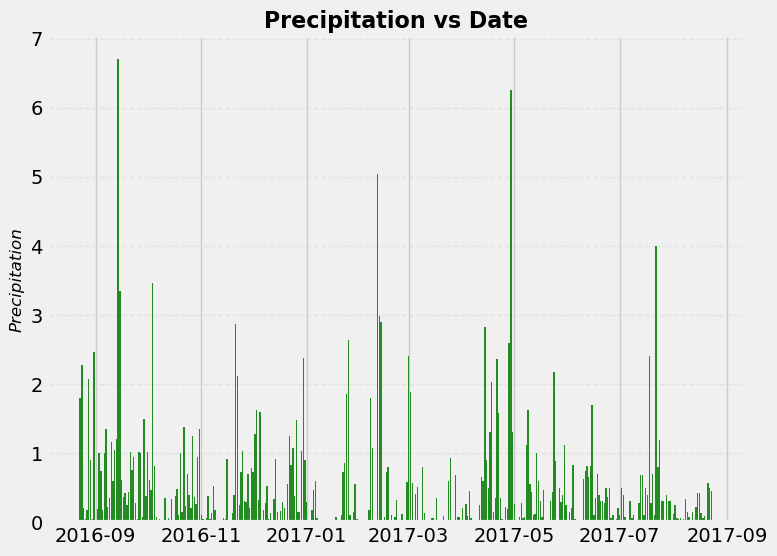

In [61]:
import datetime
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.station, Measurement.prcp).filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(precip_data, columns=["Date", "Station", "Precipitation"])
# df2 = pd.DataFrame(precip_data)

# Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)
df2.head()
df2.info()
# Use Pandas Plotting with Matplotlib to plot the data
# Step 1: Get the data


# x: df2.Date
# y: df2.Precipitation

# Step 2: Create the Canvas
plt.figure(figsize=(8,6))

# Step 3: Create the skeleton plot
plt.bar(df2.Date, df2.Precipitation, color="forestgreen")

# Step 4: Customization
plt.ylabel("Precipitation", fontsize=12, fontstyle="italic")
plt.title("Precipitation vs Date", fontsize=16, fontweight="bold")
# plt.ylim(0, 600)

plt.grid(axis="y", color="lightgrey", linestyle="--", alpha=0.5)

# Step 5: Show/Save
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [62]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


In [63]:
session.query(func.count(Station.id)).all()

[(9,)]

In [84]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = """
            SELECT 
                station,
                count(*) num_station
                        
            From 
                Measurement
            Group by 
                 station
            Order by 
                num_station desc;
            
            """
df3 = pd.read_sql(text(query), con=engine)
df3.head()
# df3.info()

,station,num_station
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [83]:
results = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
df4 = pd.DataFrame(results, columns=["Station", "Observations"])
df4.head()
# df4 = pd.DataFrame(result)

,Station,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [87]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
            SELECT 
                min(tobs) lowest,
                max(tobs) highest,
                avg(tobs) average
            From 
                Measurement
            Where 
                station = "USC00519281"
            ;"""
df5 = pd.read_sql(text(query), con=engine)
df5.head()

,lowest,highest,average
0,54.0,85.0,71.663781


In [103]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
            SELECT 
                min(tobs) lowest,
                max(tobs) highest,
                avg(tobs) average
            From 
                Measurement
            Where 
                 date >= '2016-08-23' 
                AND date <= '2017-08-23';"""
df5 = pd.read_sql(text(query), con=engine)
df5.head()

,lowest,highest,average
0,58.0,87.0,74.590583


In [89]:
results = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281" ).all()
df6 = pd.DataFrame(results, columns=["min_temp", "avg_temp", "max_temp"])
df6.head()

,min_temp,avg_temp,max_temp
0,54.0,85.0,71.663781


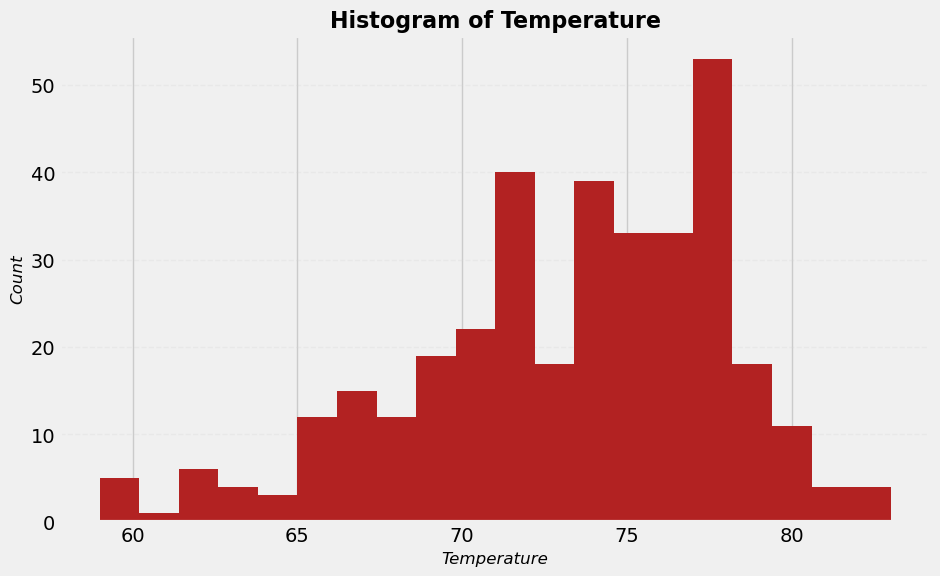

In [96]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
            SELECT 
                date,
                station,
                tobs                
            From 
                Measurement
            Where
                date >= '2016-08-23'
                And 
                station = "USC00519281" 
            ORDER BY
                date ASC
                ;
            """
# with engine.connect() as conn:
#     print(conn.execute(text(query)).fetchall())
df7 = pd.read_sql(text(query), con=engine)
df7.head(10)
# df7.info()


# Step 1: Get the Data
x = df7.tobs

# Step 2: Create the Canvas
plt.figure(figsize=(10, 6))

# Step 3: Create the basic plot
plt.hist(x, bins=20, color="firebrick")

# Step 4: customize
plt.xlabel("Temperature", fontstyle="italic", fontsize=12)
plt.ylabel("Count", fontstyle="italic", fontsize=12)
plt.title("Histogram of Temperature", fontsize=16, fontweight="bold")
# plt.ylim(0, 1400)

plt.grid(color="lightgrey", axis="y", linestyle="--", alpha=0.25)

# Step 5: show/save
plt.show()

In [101]:
# Calculate the date one year from the last date in data set.
start_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and tobs scores
results = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df8 = pd.DataFrame(results, columns=["Date", "Station", "TOBS"])

# Sort the dataframe by date
df8["Date"] = pd.to_datetime(df2['Date'])
df8 = df8.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df8.head()
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     352 non-null    datetime64[ns]
 1   Station  352 non-null    object        
 2   TOBS     352 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.4+ KB


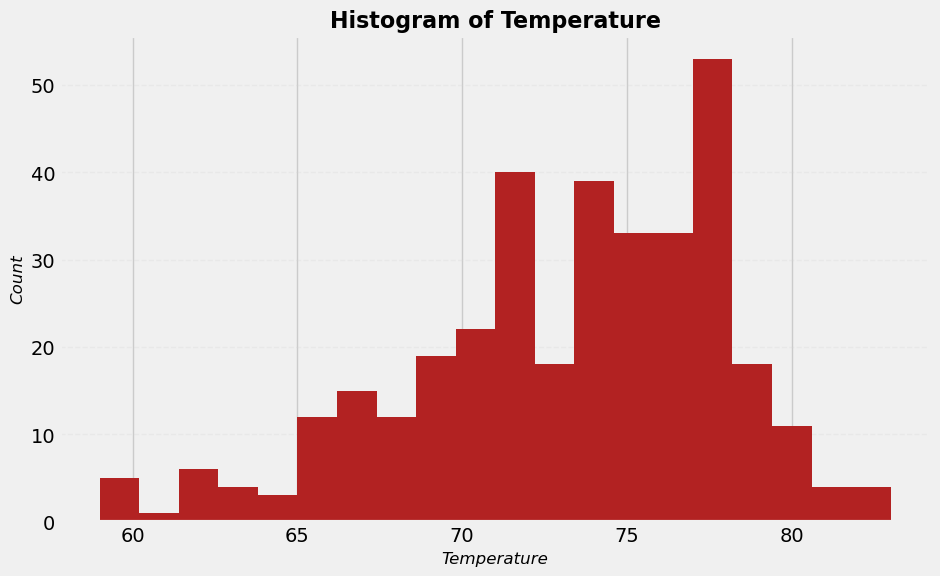

In [100]:
# Step 1: Get the Data
x = df8.TOBS

# Step 2: Create the Canvas
plt.figure(figsize=(10, 6))

# Step 3: Create the basic plot
plt.hist(x, bins=20, color="firebrick")

# Step 4: customize
plt.xlabel("Temperature", fontstyle="italic", fontsize=12)
plt.ylabel("Count", fontstyle="italic", fontsize=12)
plt.title("Histogram of Temperature", fontsize=16, fontweight="bold")
# plt.ylim(0, 1400)

plt.grid(color="lightgrey", axis="y", linestyle="--", alpha=0.25)

# Step 5: show/save
plt.show()

# Close Session

In [16]:
# Close Session
session.close()